In [104]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [105]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),
    transforms.ToTensor(),  
])

In [106]:
transform_with_augment = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transform,
])

In [107]:
dataset_dir = "synthetic_digits_dataset/"
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)
len(dataset)

10000

In [108]:
dataset[0]

(tensor([[[0.0000, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.0000],
          [0.0000, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.0000],
          [0.0000, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.0000],
          [0.0000, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745, 0.8745,
           0.8745, 0.8745, 0.8745, 0.8745, 

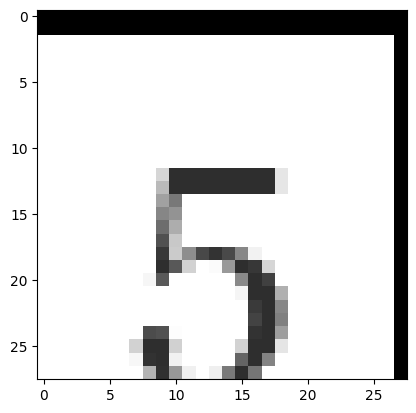

In [109]:
plt.imshow(dataset[5006][0].permute(1, 2, 0), cmap="gray")

In [110]:
train_size = int(0.8 * (len(dataset)))
test_size = int(len(dataset) - train_size)
train_size, test_size

(8000, 2000)

In [111]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(8000, 2000)

In [112]:
test_batch = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_batch = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [113]:
from torch import nn
class ModelV0(nn.Module):
  def __init__(self, input_shape, hidden_layers, output_shape):
    super().__init__()
    self.layer_stack_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layers,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.layer_stack_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_layers,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layers,
                  out_channels=hidden_layers,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.layer_stack_3 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_layers*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.layer_stack_1(x)
    # print(x.shape)
    x = self.layer_stack_2(x)
    # print(x.shape)
    x = self.layer_stack_3(x)
    # print(x.shape)
    return x

model_0 = ModelV0(input_shape=1,
                       hidden_layers=10,
                       output_shape=10).to(device)

In [114]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                         lr=0.1)

In [115]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [116]:
epochs = 10

for epoch in tqdm(range(epochs)):
  model_0.to(device)
  train_loss, train_acc = 0, 0

  model_0.train()
  for batch, (X, y) in enumerate(train_batch):
    X, y = X.to(device), y.to(device)
    # print(f"X:{X.shape}")

    y_pred = model_0(X)
    # print(f"y: {y}\n")
    # print(f"y_pred: {y_pred}")
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                           y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  model_0.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0, 0
    for batch, (X, y) in enumerate(test_batch):
      X, y = X.to(device), y.to(device)
      test_pred = model_0(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y,
                            y_pred=test_pred.argmax(dim=1))

  print(f"Train loss = {train_loss/len(train_batch)} | Train acc = {train_acc/len(train_batch)} | Test loss = {test_loss/len(test_batch)} | Test acc = {test_acc/len(test_batch)}")


 10%|██▏                   | 1/10 [00:15<02:16, 15.14s/it]

Train loss = 2.303872585296631 | Train acc = 8.482142857142858 | Test loss = 2.303020715713501 | Test acc = 12.2625


 20%|████▍                 | 2/10 [00:27<01:49, 13.65s/it]

Train loss = 2.3019473552703857 | Train acc = 10.317460317460318 | Test loss = 2.3021905422210693 | Test acc = 13.525


 30%|██████▌               | 3/10 [00:39<01:30, 12.95s/it]

Train loss = 2.2997467517852783 | Train acc = 11.458333333333334 | Test loss = 2.2976222038269043 | Test acc = 14.0875


 40%|████████▊             | 4/10 [00:52<01:16, 12.74s/it]

Train loss = 2.261120080947876 | Train acc = 21.279761904761905 | Test loss = 2.0924038887023926 | Test acc = 31.6375


 50%|███████████           | 5/10 [01:03<01:01, 12.36s/it]

Train loss = 1.6627005338668823 | Train acc = 44.49404761904762 | Test loss = 1.9815512895584106 | Test acc = 28.2625


 60%|█████████████▏        | 6/10 [01:15<00:48, 12.12s/it]

Train loss = 1.1834495067596436 | Train acc = 64.28571428571429 | Test loss = 1.4915295839309692 | Test acc = 55.3625


 70%|███████████████▍      | 7/10 [01:27<00:35, 11.99s/it]

Train loss = 0.8489254713058472 | Train acc = 73.01587301587301 | Test loss = 0.6274087429046631 | Test acc = 79.3125


 80%|█████████████████▌    | 8/10 [01:39<00:23, 11.93s/it]

Train loss = 0.5007012486457825 | Train acc = 85.01984126984127 | Test loss = 0.4406201243400574 | Test acc = 84.4625


 90%|███████████████████▊  | 9/10 [01:50<00:11, 11.85s/it]

Train loss = 0.2530449330806732 | Train acc = 92.80753968253968 | Test loss = 0.20407429337501526 | Test acc = 94.75


100%|█████████████████████| 10/10 [02:02<00:00, 12.26s/it]

Train loss = 0.14369140565395355 | Train acc = 96.23015873015873 | Test loss = 0.12702733278274536 | Test acc = 96.4125


In [117]:
torch.save(model_0.state_dict(), "model_3.pth")